In [1]:
import os
import glob
import time
import pandas as pd
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
#폴더 초기화
filePath1 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples'
filePath2 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'
filePath3 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_history'

def removeAllFile(filePath):
    if os.path.exists(filePath):
        for file in os.scandir(filePath):
            os.remove(file.path)
        return 'Remove All File'
    else:
        return 'Directory Not Found'
    
print(removeAllFile(filePath1))
print(removeAllFile(filePath2))
print(removeAllFile(filePath3))

Remove All File
Remove All File
Remove All File


# STEP 1. 데이터셋 구성하기

In [3]:
# 데이터 불러오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
# 학습이 너무 오래 걸려서 한 종류의 데이터만 추출해서 진행
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

train_x, test_x  = load_data(label=3)

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
# 픽셀값 -1, 1로 정규화

train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
# 데이터 shape 확인

train_x.shape

(5000, 32, 32, 3)

< 고양이 라벨만 가져옴 >

사이즈 32x32인 채널수 3개인 이미지가 5000장 있다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<function matplotlib.pyplot.show(close=None, block=None)>

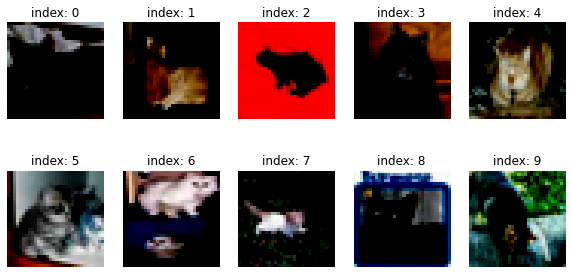

In [8]:
# 데이터 10개 확인
plt.figure(figsize=(10,5)) # 이미지 전체 프레임의 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1) # 이미지 2x5 배열로 출력 가능
    plt.imshow(train_x[i].reshape(32,32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

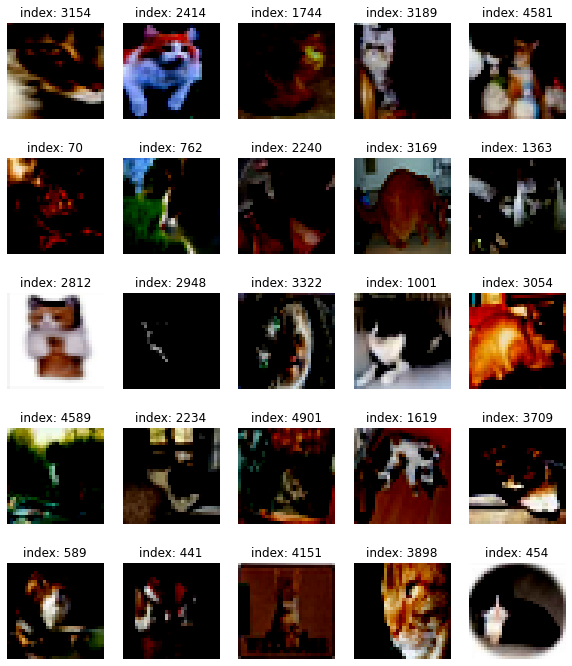

In [9]:
# 데이터 랜덤하게 25개 확인
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 5000)
    plt.imshow(train_x[random_index].reshape(32,32,3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 5000 # shuffle해줄 데이터 크기
BATCH_SIZE = 256  # 모델이 한 번에 학습할 데이터의 양. 미니 배치 학습 시 사용

``tf.data.Dataset.from_tensor_slices()`` : 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다. 

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 2. 생성자(Generator) 구현하기
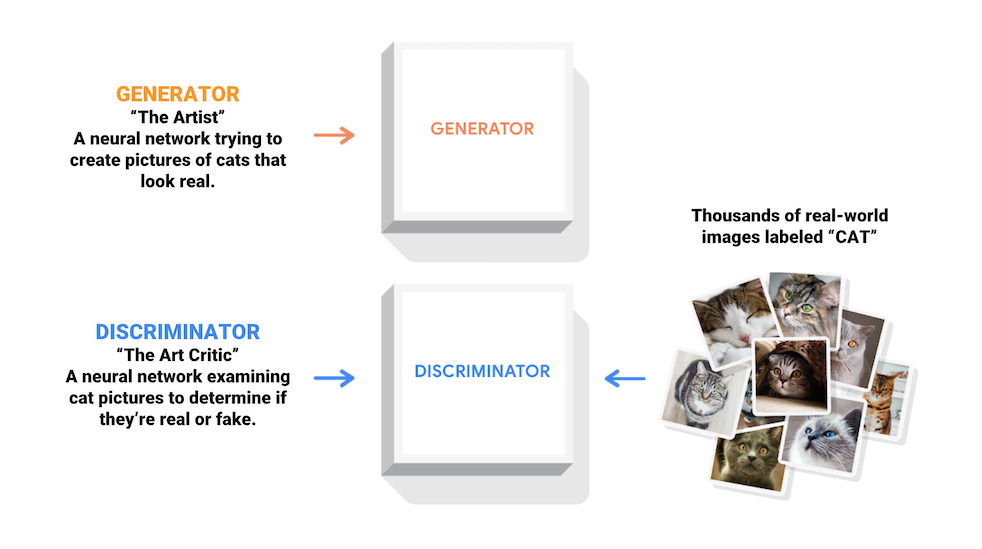
[Tensorflow 2.0 Tutorial의 DCGAN 구현을 기반](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko) -> 참고

``Conv2DTranspose`` 레이어 : Conv2D와 반대로 이미지 사이즈를 넓혀줌 <br>
**(8, 8, 256) → (16, 16, 64) → (32, 32, 3)** 순으로 이미지를 키우기

- 생성자의 입력 벡터는 (batch_size, 100)의 shape을 가진 노이즈 벡터

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 정규화
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer : Convolution 연산을 위해 1차원 벡터 3차원 벡터로 변환
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) # 픽셀값 -1~1값으로 정규화시켜 tanh 사용

    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 노이즈 벡터 생성해서 결과물 만들어보자

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
# 학습중 X
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

-> batch_size=1, (32, 32, 3) 사이즈 이미지 생성

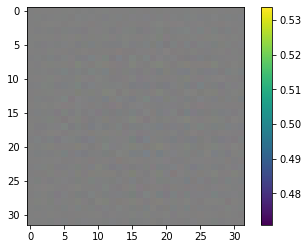

In [16]:
plt.imshow(generated_image[0]* 0.5 + 0.5)
plt.colorbar()
plt.show()

# STEP 3. 판별자 구현하기
``Conv2D`` 층으로 이미지의 크기를 점점 줄여나갑니다.<br>
**(32, 32, 3) → (16, 16, 64) → (8, 8, 128)** 까지 줄어든다

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

# STEP 4. 손실 함수와 최적화 함수

## 4.1 손실함수
``tf.keras.losse.BinaryCrossEntropy()`` 클래스 : 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정

``from_logits=True`` 로 옵션 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용에 0~1 사이의 값으로 정규화한 후 계산해줌

Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0이라고 가정

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

``cross_entropy`` 를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용

- ``fake_output`` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image) 
- ``real_output`` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

``tf.ones_like()``,  ``tf.zeros_like()`` : 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용

### 4.1.1 generator_ loss 구현

생성자는 fake_output이 1에 가까워지기를 원함. <br>
``tf.ones_like``와의 교차 엔트로피값을 계산

> 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

### 4.1.2 discriminator_loss 구현
discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산

> **real_output**은 **1로 채워진 벡터(label)**와, **fake_output**은 **0으로 채워진 벡터(label)**와 비교
> 최종 discriminator_loss 값은 이 둘을 더한 값

``tf.ones_like(real_output)`` 와 ``tf.zeros_like(fake_output)``은 여기서 **정답 라벨**이다.


In [21]:
def discriminator_loss(real_output, fake_output):
    # real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    real_loss = cross_entropy(tf.add(tf.ones_like(real_output),-0.1), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 4.2 discriminator accuracy

#### accuracy가 1.0이면 좋은걸까? 
**NO!!** 그건 생성자에서 fake_output을 real_output에 가깝게 못 생성했다는 뜻
그렇기 때문에 real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다.

-  (1) ``tf.math.greater_equal(real_output, tf.constant([0.5])`` : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - ``>> tf.Tensor([False, False, True, True])``


- (2) ``tf.cast( (1), tf.float32)`` : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - ``>> tf.Tensor([0.0, 0.0, 1.0, 1.0])``


- (3) ``tf.reduce_mean( (2))`` : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - ``>> 0.5``


In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 4.3 최적화 함수(optimizer)

생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이다. <br>
때문에 **optimizer를 따로** 만들어주어야 한다!

옵티마이저에 옵션 추가 <br>
``clipvalue=1.0`` : 그래디언트 클리핑 
``decay = 1e-8``  : 안정된 훈련위해 학습률 감쇠 사용

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, clipvalue=1.0, decay = 1e-8)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, clipvalue=1.0, decay = 1e-8)

16장의 샘플 생성해 진전과정 확인해보기

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 5. 훈련과정 설계

#### @tf.function 데코레이터?
-> @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환된다.

In [25]:
# 예시 1
# import numpy as np
# import tensorflow as tf

# def f(x, y):
#   print(type(x))
#   print(type(y))
#   return x ** 2 + y

# x = np.array([2, 3])
# y = np.array([3, -2])
# f(x, y)

In [26]:
# 예시 2
# import numpy as np
# import tensorflow as tf

# @tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
# def f(x, y):
#   print(type(x))
#   print(type(y))
#   return x ** 2 + y

# x = np.array([2, 3])
# y = np.array([3, -2])
# f(x, y)

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

### 5.1 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # plt.imshow(predictions[i, :, :, 0])
        plt.imshow(predictions[i] * 0.5 + 0.5) # 0~1 사이로 바꿔줘야 컬러로 보임
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))


    plt.show()

### 5.2 history 그래프로 시각화

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 5.3 모델 저장위한 checkpoint 만들기

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 6. 학습 과정 진행하기
위에서 이미 만든 함수 합치기!

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [32]:
save_every = 5 # 모델 저장하는 간격
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

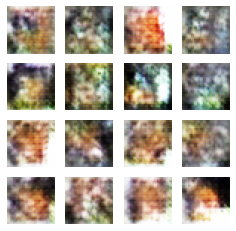

Time for training : 1366 sec


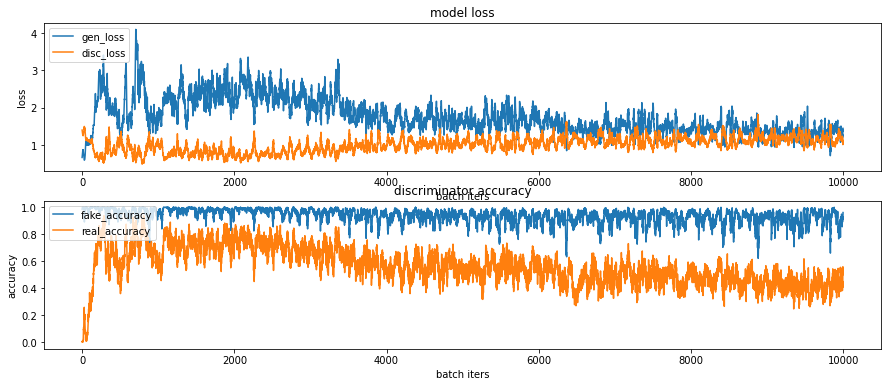

CPU times: user 24min 57s, sys: 4min 21s, total: 29min 19s
Wall time: 22min 47s


In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 학습 과정 시각화

In [43]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif

-rw-r--r-- 1 root root 1696613 Feb 15 17:31 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif


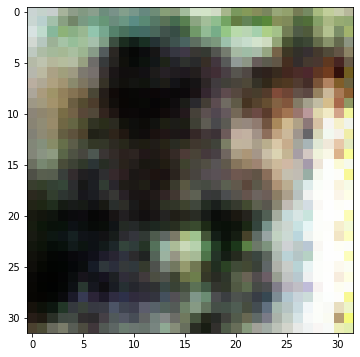

In [44]:
# checkpoint 모듈을 활용하여 모델을 로드하는 코드
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [39]:
EPOCHS = 500

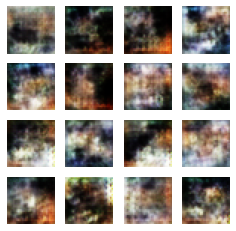

Time for training : 1374 sec


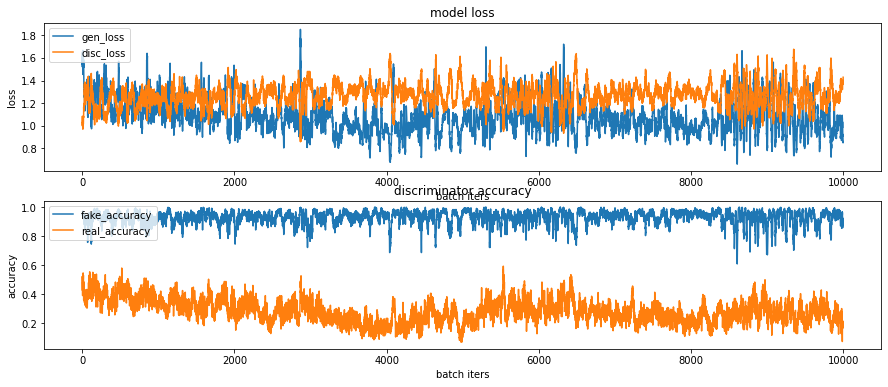

CPU times: user 25min, sys: 4min 24s, total: 29min 24s
Wall time: 22min 55s


In [40]:
%%time
train(train_dataset, EPOCHS, save_every)

# STEP 7. GAN 훈련 과정 개선하기

## 회고
---

라벨을 고양이 하나만 뽑아서 600에포크 넘게 돌려봐도 도저히 고양이처럼 생성이 되지않는다.

1. ``One-sided label Smoothing`` : 판별자 모델 Real image를 1이 아닌 0.9로 줘서 라벨에 노이즈 주기
2. 판별자 모델에 Conv2D Layer 1개 더 추가
3. 판별자 모델에 dropout을 0.3 -> 0.5로 
4. optimizer에 (clipvalue=1.0, decay = 1e-8) 옵션 추가

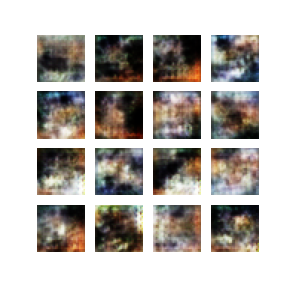

- 모델을 개선하고 나서 그래도 고양이 형체가 보이기 시작한다. 
- 그래도 너무 희미해서 만족스럽진 않다.
- GAN의 좀 더 고차원적인 모델을 적용하는 방법을 연구해봐야겠다.